<span style="color:darkcyan;">**Téléchargement des bibliothèques**</span>

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
!pip install openpyxl


<span style="color:darkcyan;">**Importation de la base de données et création du data frame**</span>

In [107]:
df = pd.read_excel('/home/onyxia/work/Projet_Python-pour-la-data-science/données_vols.xlsx')
# Afficher les 5 premières lignes pour vérifier
print(df.head(5))

  Carrier Code    Date (MM/DD/YYYY)  Flight Number Tail Number  \
0           AA  2020-01-01 00:00:00              1      N110AN   
1           AA  2020-01-01 00:00:00              3      N111ZM   
2           AA  2020-01-01 00:00:00            111      N663AW   
3           AA  2020-01-01 00:00:00            117      N113AN   
4           AA  2020-01-01 00:00:00            179      N103NN   

  Destination Airport Scheduled departure time Actual departure time  \
0                 LAX                 07:30:00              07:30:00   
1                 LAX                 12:30:00              12:24:00   
2                 CLT                 12:00:00              13:11:00   
3                 LAX                 19:30:00              19:26:00   
4                 SFO                 10:30:00              10:25:00   

   Scheduled elapsed time (Minutes)  Actual elapsed time (Minutes)  \
0                               393                            404   
1                             

In [23]:
# Vérifier si le DataFrame contient des valeurs manquantes
print(df.isnull().values.any())

True


In [24]:
# Nombre de valeurs manquantes par colonne
print(df.isnull().sum())

Carrier Code                                  0
Date (MM/DD/YYYY)                             0
Flight Number                                 0
Tail Number                                 226
Destination Airport                           0
Scheduled departure time                      0
Actual departure time                         0
Scheduled elapsed time (Minutes)              0
Actual elapsed time (Minutes)                 0
Departure delay (Minutes)                     0
Wheels-off time                               0
Taxi-Out time (Minutes)                       0
Delay Carrier (Minutes)                       0
Delay Weather (Minutes)                       0
Delay National Aviation System (Minutes)      0
Delay Security (Minutes)                      0
Delay Late Aircraft Arrival (Minutes)         0
dtype: int64


<span style="color:lightpink;">**Commentaire de la sortie**</span>

<small>La seule variable qui présente des valeurs manquantes est **Tail Number**. Cependant il ne s'agit pas d'une variable explicative dans notre modèle, ainsi ces valeurs manquantes ne nécessite aucun traitement.</small>

In [25]:
# Filtrer les lignes avec des valeurs manquantes
missing_values_rows = df[df.isnull().any(axis=1)]

# Afficher les lignes avec des valeurs manquantes
print(missing_values_rows)

      Carrier Code    Date (MM/DD/YYYY)  Flight Number Tail Number  \
13937           AA           03/18/2020            796         NaN   
14121           AA           03/19/2020            796         NaN   
14304           AA           03/20/2020            796         NaN   
14492           AA           03/21/2020            796         NaN   
15035           AA           03/24/2020            177         NaN   
...            ...                  ...            ...         ...   
35523           AA           07/28/2020            243         NaN   
35524           AA           07/28/2020            250         NaN   
35694           AA           07/29/2020            250         NaN   
35706           AA           07/29/2020           2452         NaN   
49330           AA  2021-01-11 00:00:00            595         NaN   

      Destination Airport Scheduled departure time Actual departure time  \
13937                 EGE                 10:59:00              00:00:00   
14121  

<span style="color:darkcyan;">**Extraction de la date du jour du vol de la colonne Date (MM/DD/YYYY)**</span>

<small>D'après la sortie du code précédent, nous pouvons clairement voir que la colonne **Date (MM/DD/YYYY)** ne contient pas uniquement la date du jour du vol mais aussi la chaîne de caractère **00:00:00** qui renvoie à **l'heure du début d'un jour**.</small>

In [108]:
# Extraire uniquement la date de la colonne Date (MM/DD/YYYY) dans la nouvelle colonne Date
df['Date'] = pd.to_datetime(df['Date (MM/DD/YYYY)'], format='%m/%d/%Y').dt.date

# Afficher la colonne Date
print(df.Date)

0        2020-01-01
1        2020-01-01
2        2020-01-01
3        2020-01-01
4        2020-01-01
            ...    
57405    2023-12-31
57406    2023-12-31
57407    2023-12-31
57408    2023-12-31
57409    2023-12-31
Name: Date, Length: 57410, dtype: object


<span style="color:darkcyan;">**Création de la colonne Weekday_Flight**</span>

<small>Nous aimerions aussi voir si **le retard d'un vol peut être lié au jour de la semaine où le vol aura lieu**. Pour cela, il est nécessaire de créer une colonne contenant le jour de la semaine **(Monday, Tuesday, Wednesday, Thursday, Friday, Saturday, Sunday)** correspondant à chaque vol de notre data frame.
</small>

In [109]:
# Convertir la colonne 'Date' en format datetime 
df['Date'] = pd.to_datetime(df['Date'])

# Créer la colonne Weekday_Flight avec les jours de la semaine correspondant aux dates des vols
df['Weekday_Flight'] = df['Date'].dt.day_name()

# Afficher Date et Weekday_Flight
print(df[['Date','Weekday_Flight']])

            Date Weekday_Flight
0     2020-01-01      Wednesday
1     2020-01-01      Wednesday
2     2020-01-01      Wednesday
3     2020-01-01      Wednesday
4     2020-01-01      Wednesday
...          ...            ...
57405 2023-12-31         Sunday
57406 2023-12-31         Sunday
57407 2023-12-31         Sunday
57408 2023-12-31         Sunday
57409 2023-12-31         Sunday

[57410 rows x 2 columns]


<span style="color:darkcyan;">**Création de la colonne Season**</span>

<small> La variable **"saison"** peut influencer les retards des vols en raison des **variations météorologiques** et des **volumes de trafic** spécifiques à chaque période de l'année. Par exemple, l’hiver apporte souvent des conditions difficiles comme la neige ou le brouillard, tandis que l’été, marqué par un trafic élevé, peut être perturbé par des orages ou des surcharges aéroportuaires. Ainsi, en tenant compte des saisons, il devient possible de mieux comprendre et anticiper les facteurs contribuant aux retards. </small>

In [110]:
# Définir une fonction qui détermine pour une date données la saison correspondante
def get_season(date):
    year = date.year
    if date >= pd.Timestamp(year=year, month=3, day=21) and date < pd.Timestamp(year=year, month=6, day=21):
        return 'Printemps'
    elif date >= pd.Timestamp(year=year, month=6, day=21) and date < pd.Timestamp(year=year, month=9, day=23):
        return 'Été'
    elif date >= pd.Timestamp(year=year, month=9, day=23) and date < pd.Timestamp(year=year, month=12, day=21):
        return 'Automne'
    else:
        return 'Hiver'


# Convertir la colonne Date en datetime 
df['Date'] = pd.to_datetime(df['Date'])

# Appliquer la fonction sur la colonne Date du dataframe
df['Season'] = df['Date'].apply(get_season)

# Afficher  des observations aléatoires du DataFrame
print(df.Season[1000:1010])
print(df.Season[2000:2010])


1000    Printemps
1001    Printemps
1002    Printemps
1003    Printemps
1004    Printemps
1005    Printemps
1006    Printemps
1007    Printemps
1008    Printemps
1009    Printemps
Name: Season, dtype: object
2000    Automne
2001    Automne
2002    Automne
2003    Automne
2004    Automne
2005    Automne
2006    Automne
2007    Automne
2008    Automne
2009    Automne
Name: Season, dtype: object


<span style="color:darkcyan;">**Création de la colonne Period_Day**</span>

In [111]:
# Définir une fonction pour attribuer la période de la journée
def definir_periode(heure):
    if heure >= pd.to_datetime('06:00', format='%H:%M').time() and heure < pd.to_datetime('12:00', format='%H:%M').time():
        return 'Matin'
    elif heure >= pd.to_datetime('12:00', format='%H:%M').time() and heure < pd.to_datetime('18:00', format='%H:%M').time():
        return 'Après-midi'
    else:
        return 'Soir'

# Convertir la colonne en type datetime
df['Scheduled departure time'] = pd.to_datetime(df['Scheduled departure time'], format='%H:%M:%S')

# Appliquer la fonction pour créer une nouvelle colonne
df['Period_Day'] = df['Scheduled departure time'].dt.time.apply(definir_periode)

# Reconvertir les colonnes "Scheduled departure time" et "Actual departure time" pour ne garder que l'heure 
df['Scheduled departure time'] = df['Scheduled departure time'].dt.time

# Afficher les colonnes Period_Day et Scheduled departure time
print(df[['Scheduled departure time','Period_Day']])

      Scheduled departure time  Period_Day
0                     07:30:00       Matin
1                     12:30:00  Après-midi
2                     12:00:00  Après-midi
3                     19:30:00        Soir
4                     10:30:00       Matin
...                        ...         ...
57405                 17:29:00  Après-midi
57406                 12:30:00  Après-midi
57407                 06:59:00       Matin
57408                 08:59:00       Matin
57409                 12:59:00  Après-midi

[57410 rows x 2 columns]


<span style="color:darkcyan;">**Création de notre variable cible Y=Delay**</span>

<small> Le **retard d'un vol au départ** se définit comme **l'écart entre l'heure de départ ou d'arrivée prévue d'un vol, telle qu'indiquée dans le programme, et l'heure réelle à laquelle le vol décolle**.. Un vol est souvent considéré en retard si cet écart dépasse un seuil défini, par exemple 5 minutes.
</small>

In [112]:
# Convertir les colonnes "Scheduled departure time" et "Actual departure time" en objets datetime
df['Scheduled departure time'] = pd.to_datetime(df['Scheduled departure time'], format='%H:%M:%S')
df['Actual departure time'] = pd.to_datetime(df['Actual departure time'], format='%H:%M:%S')

# Création de la variable cible "Retard en calculant la différence en minutes et appliquer la condition
df['Retard'] = ((df['Actual departure time'] - df['Scheduled departure time']).dt.total_seconds() / 60 > 0).astype(int)

# Afficher les colonnes "Actual departure time", "Scheduled departure time" et "Retard"
print(df[['Actual departure time', 'Scheduled departure time', 'Retard']])


      Actual departure time Scheduled departure time  Retard
0       1900-01-01 07:30:00      1900-01-01 07:30:00       0
1       1900-01-01 12:24:00      1900-01-01 12:30:00       0
2       1900-01-01 13:11:00      1900-01-01 12:00:00       1
3       1900-01-01 19:26:00      1900-01-01 19:30:00       0
4       1900-01-01 10:25:00      1900-01-01 10:30:00       0
...                     ...                      ...     ...
57405   1900-01-01 17:25:00      1900-01-01 17:29:00       0
57406   1900-01-01 12:26:00      1900-01-01 12:30:00       0
57407   1900-01-01 06:57:00      1900-01-01 06:59:00       0
57408   1900-01-01 08:53:00      1900-01-01 08:59:00       0
57409   1900-01-01 12:57:00      1900-01-01 12:59:00       0

[57410 rows x 3 columns]


In [113]:

# Reconvertir les colonnes "Scheduled departure time" et "Actual departure time" pour ne garder que l'heure 
df['Scheduled departure time'] = df['Scheduled departure time'].dt.time
df['Actual departure time'] = df['Actual departure time'].dt.time

# Afficher les colonnes "Actual departure time", "Scheduled departure time" et "Retard"
print(df[['Actual departure time', 'Scheduled departure time', 'Retard']])



      Actual departure time Scheduled departure time  Retard
0                  07:30:00                 07:30:00       0
1                  12:24:00                 12:30:00       0
2                  13:11:00                 12:00:00       1
3                  19:26:00                 19:30:00       0
4                  10:25:00                 10:30:00       0
...                     ...                      ...     ...
57405              17:25:00                 17:29:00       0
57406              12:26:00                 12:30:00       0
57407              06:57:00                 06:59:00       0
57408              08:53:00                 08:59:00       0
57409              12:57:00                 12:59:00       0

[57410 rows x 3 columns]


<span style="color:darkcyan;">**Encodage des variables qualitatives**</span>

In [114]:
!pip install scikit-learn
import sklearn
from sklearn.preprocessing import LabelEncoder

<span style="color:lightpink;">**Encodage de la variable Weekday_Flight**</span>

In [115]:
# Initialiser l'encodeur
label_encoder = LabelEncoder()

# Encoder de la variable Weekday_Flight
df['Weekday_Flight_encoded'] = label_encoder.fit_transform(df['Weekday_Flight'])

# Récupérer les modalités de Weekday_Flight et leurs codes correspondant dans la variable Weekday_Flight_encoded
modalites_et_codes = list(zip(label_encoder.classes_, range(len(label_encoder.classes_))))

# Afficher les modalités et leurs codes
print("Modalités et leurs codes :", modalites_et_codes)

#Afficher les colonnes Weekday_Flight et Weekday_Flight_encoded
print(df[['Weekday_Flight','Weekday_Flight_encoded']])

Modalités et leurs codes : [('Friday', 0), ('Monday', 1), ('Saturday', 2), ('Sunday', 3), ('Thursday', 4), ('Tuesday', 5), ('Wednesday', 6)]
      Weekday_Flight  Weekday_Flight_encoded
0          Wednesday                       6
1          Wednesday                       6
2          Wednesday                       6
3          Wednesday                       6
4          Wednesday                       6
...              ...                     ...
57405         Sunday                       3
57406         Sunday                       3
57407         Sunday                       3
57408         Sunday                       3
57409         Sunday                       3

[57410 rows x 2 columns]


<span style="color:lightpink;">**Encodage de la variable Season**</span>

In [116]:
# Initialiser l'encodeur
label_encoder = LabelEncoder()

# Encoder de la variable Season
df['Season_encoded'] = label_encoder.fit_transform(df['Season'])

# Récupérer les modalités de Season et leurs codes correspondant dans la variable Season_encoded
modalites_et_codes = list(zip(label_encoder.classes_, range(len(label_encoder.classes_))))

# Afficher les modalités et leurs codes
print("Modalités et leurs codes :", modalites_et_codes)

#Afficher des valeurs aléatoires de Season et Season_encoded
print(df[['Season', 'Season_encoded']][1000:1005])
print(df[['Season', 'Season_encoded']][2000:2005])
print(df[['Season', 'Season_encoded']][3000:3005])


Modalités et leurs codes : [('Automne', 0), ('Hiver', 1), ('Printemps', 2), ('Été', 3)]
         Season  Season_encoded
1000  Printemps               2
1001  Printemps               2
1002  Printemps               2
1003  Printemps               2
1004  Printemps               2
       Season  Season_encoded
2000  Automne               0
2001  Automne               0
2002  Automne               0
2003  Automne               0
2004  Automne               0
     Season  Season_encoded
3000  Hiver               1
3001  Hiver               1
3002  Hiver               1
3003  Hiver               1
3004  Hiver               1


<span style="color:lightpink;">**Encodage de la variable Period_Day**</span>

In [117]:
# Initialiser l'encodeur
label_encoder = LabelEncoder()

# Encoder de la variable Period_Day
df['Period_Day_encoded'] = label_encoder.fit_transform(df['Period_Day'])

# Récupérer les modalités de Period_Day et leurs codes correspondant dans la variable Period_Day_encoded
modalites_et_codes = list(zip(label_encoder.classes_, range(len(label_encoder.classes_))))

# Afficher les modalités et leurs codes
print("Modalités et leurs codes :", modalites_et_codes)

#Afficher les colonnes Period_Day et Period_Day_encoded
print(df[['Period_Day','Period_Day_encoded']])

Modalités et leurs codes : [('Après-midi', 0), ('Matin', 1), ('Soir', 2)]
       Period_Day  Period_Day_encoded
0           Matin                   1
1      Après-midi                   0
2      Après-midi                   0
3            Soir                   2
4           Matin                   1
...           ...                 ...
57405  Après-midi                   0
57406  Après-midi                   0
57407       Matin                   1
57408       Matin                   1
57409  Après-midi                   0

[57410 rows x 2 columns]


<span style="color:lightpink;">**Encodage de la variable Destination Airport**</span>

In [118]:
# Initialiser l'encodeur
label_encoder = LabelEncoder()

# Encoder de la variable Destination Airport
df['Destination_encoded'] = label_encoder.fit_transform(df['Destination Airport'])

# Récupérer les modalités de Destination Airport et leurs codes correspondant dans la variable Destination_encoded
modalites_et_codes1 = list(zip(label_encoder.classes_, range(len(label_encoder.classes_))))

# Afficher les modalités et leurs codes
print("Modalités et leurs codes :", modalites_et_codes1)

#Afficher les colonnes Destination Airport et Destination_encoded
print(df[['Destination Airport','Destination_encoded']])

Modalités et leurs codes : [('AUS', 0), ('BOS', 1), ('CLT', 2), ('DCA', 3), ('DFW', 4), ('EGE', 5), ('FLL', 6), ('JAC', 7), ('LAS', 8), ('LAX', 9), ('MIA', 10), ('ORD', 11), ('PHX', 12), ('RDU', 13), ('SAN', 14), ('SAT', 15), ('SFO', 16), ('SNA', 17), ('STT', 18)]
      Destination Airport  Destination_encoded
0                     LAX                    9
1                     LAX                    9
2                     CLT                    2
3                     LAX                    9
4                     SFO                   16
...                   ...                  ...
57405                 AUS                    0
57406                 MIA                   10
57407                 AUS                    0
57408                 ORD                   11
57409                 PHX                   12

[57410 rows x 2 columns]


In [119]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57410 entries, 0 to 57409
Data columns (total 26 columns):
 #   Column                                    Non-Null Count  Dtype         
---  ------                                    --------------  -----         
 0   Carrier Code                              57410 non-null  object        
 1   Date (MM/DD/YYYY)                         57410 non-null  object        
 2   Flight Number                             57410 non-null  int64         
 3   Tail Number                               57184 non-null  object        
 4   Destination Airport                       57410 non-null  object        
 5   Scheduled departure time                  57410 non-null  object        
 6   Actual departure time                     57410 non-null  object        
 7   Scheduled elapsed time (Minutes)          57410 non-null  int64         
 8   Actual elapsed time (Minutes)             57410 non-null  int64         
 9   Departure delay (Minutes)   

### **Partie 2**

(à réadapter les interpretations pour la base fusionnée par la suite)

<span style="color:darkcyan;">**Analyse descriptive**</span>

**Dans cette partie, il s'agit d'une description complète de notre dataset ainsi qu'une analyse orientée sur les retards.**

<span style="color:darkmagenta;">**Contexte Général**</span>

**<small> Pour la compagnie aérienne American Airlines, nous dénombrons <span style="color:orange;">**57410 vols**</span> de départ de l’aéroport JFK sur la période allant du 01 Janvier 2020 jusqu'au 12 Août 2024. Cela représente en moyenne <span style="color:orange;">**32 vols**</span> par jour sur cette période.</small>**

In [121]:
#nombre de vols sur la période de notre dataset
nb_vols = len(df)

#nombre moyen de vols par jour sur cette période
df['Date'] = pd.to_datetime(df['Date'])
date_min = df['Date'].min()
date_max = df['Date'].max()
nb_moyen = round(nb_vols / ((date_max - date_min).days + 1),2)

print("nb_vols = ",nb_vols)
print("nb_moyen = ",nb_moyen)

df['Date']

nb_vols =  57410
nb_moyen =  31.82


0       2020-01-01
1       2020-01-01
2       2020-01-01
3       2020-01-01
4       2020-01-01
           ...    
57405   2023-12-31
57406   2023-12-31
57407   2023-12-31
57408   2023-12-31
57409   2023-12-31
Name: Date, Length: 57410, dtype: datetime64[ns]

**<small><span style="color:orange;">Distribution des vols par jour</span></small>**

**<small>Nous obtenons <span style="color:orange;">une répartition uniforme sur les jours de la semaine</span> des vols de American Airlines de départ de l'aéroport JFK, avec une légère baisse le samedi (13.66%) et une légère hausse des volumétries de départs le lundi (14.49%).</small>**

/tmp/ipykernel_475574/1493243718.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=pourcentage_vols.index, y=pourcentage_vols.values, palette="viridis")  # Création du graphique


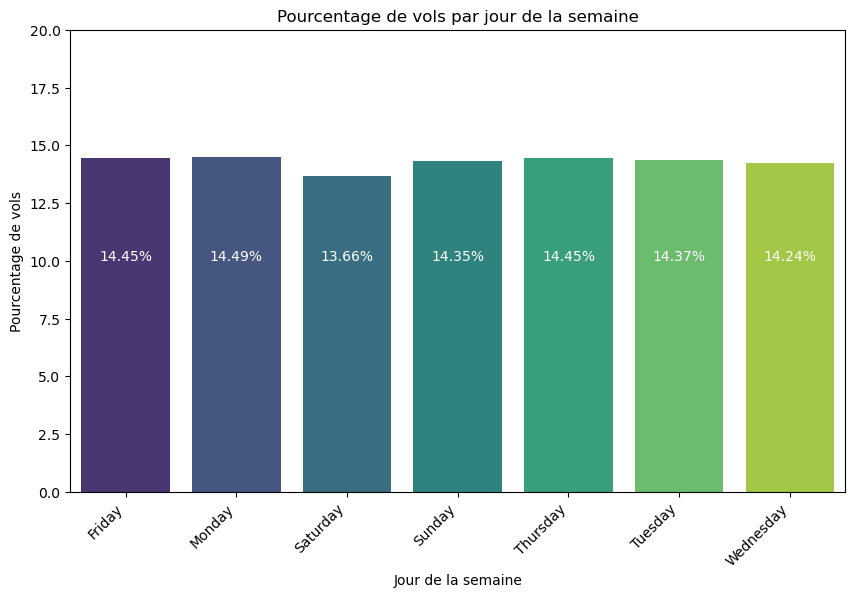

In [122]:
# Ordre des jours de la semaine
order_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Nombre total de vols
nb_vols = len(df)

# Nombre de vols par jour de la semaine
nb_vols_jour = df.groupby('Weekday_Flight').size()

# Calcul des pourcentages de vols par jour de la semaine
pourcentage_vols = (nb_vols_jour / nb_vols) * 100

# Convertir l'index en un type catégoriel avec un ordre spécifique
#pourcentage_vols.index = pd.Categorical(pourcentage_vols.index, categories=order_days, ordered=True)

# Réordonner les données
#pourcentage_vols = pourcentage_vols.sort_index()

# Création du graphique à barres
plt.figure(figsize=(10, 6))  
sns.barplot(x=pourcentage_vols.index, y=pourcentage_vols.values, palette="viridis")  # Création du graphique
plt.title('Pourcentage de vols par jour de la semaine')
plt.xlabel('Jour de la semaine')
plt.ylabel('Pourcentage de vols')

# Rotation des étiquettes sur l'axe x pour une meilleure lisibilité
plt.xticks(rotation=45, ha='right')

# Ajouter les pourcentages sur les barres
for i, value in enumerate(pourcentage_vols.values):
    plt.text(i, 10, f"{value:.2f}%", ha='center', va='baseline', color='white')  # Affichage des pourcentages en blanc

# Réglage de l'axe y
plt.ylim(0, 20)

plt.show()

<span style="color:darkmagenta;">**Focus sur les vols retardés**</span>

<small><span style="color:orange;">**17150 vols</span> de la compagnie AA de départ de l'aéroport JFK sont concernés par un retard au décollage, constituant un pourcentage d' à peu près <span style="color:orange;">30%</span>. 
La moyenne des retards pour les vols concernés est de <span style="color:orange;">39.36 minutes</span>, pour une valeur médiane de <span style="color:orange;">14 minutes</span> ( 50% des vols retardés sont d'un retard inférieur à 14 minutes par rapport à leur créneau de décollage programmé). Le retard au décollage maximal qu'a enregistré la compagnie à l'aéroport JFK est de <span style="color:orange;">1627 minutes</span>, soit <span style="color:orange;">27.12 heures</span> (il s'agit probablement d'un vol qui a été reporté).**</small>

Nombre de vols retardés est  17150 vols.
Le retard maximal est de  1627 minutes, soit 27.12 heures.
La moyenne des retards est  39.36 minutes.
La médiane des retards est  14.0 minutes.


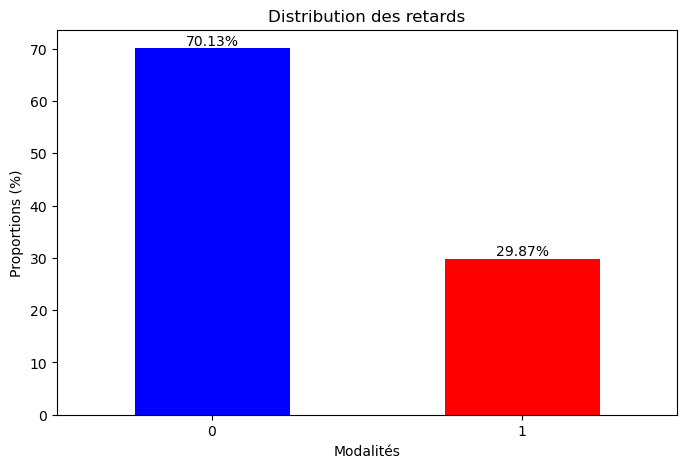

In [125]:
# Création d'un dataset pour l'analyse des vols uniquement retardés
vols_retardes = df[df['Retard'] == 1].copy()


# Comptage du nombre de vols en retards
count_vols_retardes = len(vols_retardes)

# Recherche du vols le plus retardé
retard_max = round(vols_retardes['Departure delay (Minutes)'].max(),2) 
retard_max_heures = round(retard_max/60,2)

# La moyenne et la médiane des retards
retard_moy = round(vols_retardes['Departure delay (Minutes)'].mean(),2)
retard_med = round(vols_retardes['Departure delay (Minutes)'].median(),2)

print("Nombre de vols retardés est ",count_vols_retardes,"vols.")
print("Le retard maximal est de ",retard_max,"minutes, soit",retard_max_heures,"heures.")
print("La moyenne des retards est ",retard_moy,"minutes.")
print("La médiane des retards est ",retard_med,"minutes.")

# Calcul des pourcentages pour chaque modalité (retard/non retard)
modalites = (df['Retard'].value_counts(normalize=True) * 100).round(2)

# Création du graphique en barres
ax = modalites.plot(kind='bar', color=['blue', 'red'], figsize=(8, 5))
plt.title('Distribution des retards')
plt.xlabel('Modalités')
plt.ylabel('Proportions (%)')

# Ajout des annotations pour indiquer les pourcentages au-dessus des barres
for i, v in enumerate(modalites):
    ax.annotate(f"{v}%", xy=(i, v), ha='center', va='bottom')

plt.xticks(rotation=0)

# Affichage du graphique
plt.show()

**<small><span style="color:orange;">Distribution des retards au départ par fréquence</span></small>**

<small>**En observant la distribution des retards par leur fréquence, nous obtenons une distribution qui <span style="color:orange;">ressemble à une loi exponentielle</span>, autour de la moyenne de 39.36 minutes et avec <span style="color:orange;">un étalement régulier des fréquences</span> vers le maximum de 1627 minutes**.</small>

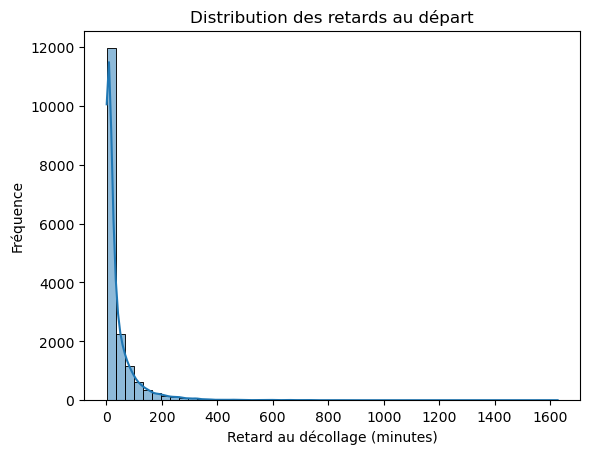

In [127]:
import seaborn as sns
# Distribution des retards d'arrivée
sns.histplot(data=vols_retardes, x='Departure delay (Minutes)', bins=50, kde=True)

# Ajout des titres et des libellés
plt.title('Distribution des retards au départ')
plt.xlabel('Retard au décollage (minutes)')
plt.ylabel('Fréquence')

# Affichage
plt.show()

**<small><span style="color:orange;">Distribution des retards au départ par mois et par saison</span></small>**

<small>**Pour la répartition mensuelle des retards des vols de la compagnie au départ de l'aéroport JFK, nous observons <span style="color:orange;">une faible saisonnalité l'été</span> de juin à août. Inversement les mois mars et novembre sont le moins impactés par les retards.**</small>

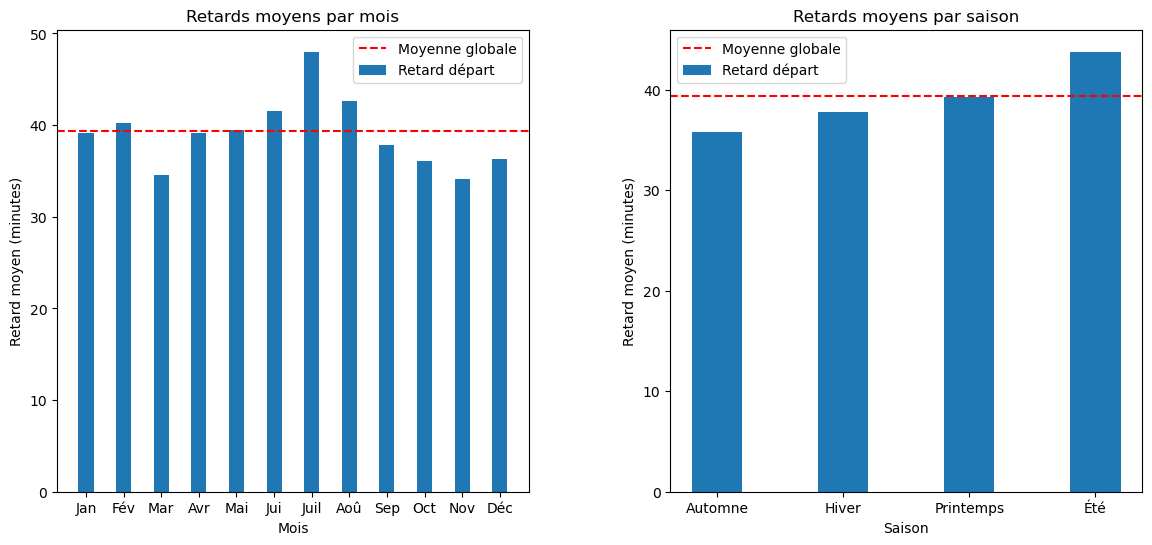

In [191]:
# Groupement des données par mois et calcul des retards moyens pour chaque mois
vols_retardes['Month']=vols_retardes['Date'].dt.month
monthly_dep_delay = vols_retardes.groupby('Month')['Departure delay (Minutes)'].mean()  

# Calcul des retards moyens au départ par mois
retard_moy_mois = vols_retardes['Departure delay (Minutes)'].mean()

# Calcul des retards moyens par saison
saison_dep_delay = vols_retardes.groupby('Season')['Departure delay (Minutes)'].mean()  

# Création de la figure et de la grille de graphiques
plt.figure(figsize=(14, 6))

# Premier graphique : retards moyens par mois
plt.subplot(1, 2, 1)  # 1 ligne, 2 colonnes, graphique 1
plt.bar(monthly_dep_delay.index, monthly_dep_delay.values, width=0.4, label='Retard départ')

# Ajout de la moyenne globale des retards au départ en une ligne
plt.axhline(y=retard_moy_mois, color='r', linestyle='--', label='Moyenne globale')

# Ajout des titres et des libellés
months = ['Jan', 'Fév', 'Mar', 'Avr', 'Mai', 'Jui', 'Juil', 'Aoû', 'Sep', 'Oct', 'Nov', 'Déc']
plt.xticks(monthly_dep_delay.index, [months[i-1] for i in monthly_dep_delay.index])
plt.title('Retards moyens par mois')
plt.xlabel('Mois')
plt.ylabel('Retard moyen (minutes)')
plt.legend()

# Deuxième graphique : retards moyens par saison
plt.subplot(1, 2, 2)  # 1 ligne, 2 colonnes, graphique 2
plt.bar(saison_dep_delay.index, saison_dep_delay.values, width=0.4, label='Retard départ')

# Ajout de la moyenne globale des retards au départ en une ligne
plt.axhline(y=retard_moy_mois, color='r', linestyle='--', label='Moyenne globale')

# Ajout des titres et des libellés
plt.title('Retards moyens par saison')
plt.xlabel('Saison')
plt.ylabel('Retard moyen (minutes)')
plt.legend()

# Ajuster l'espacement entre les graphiques 
plt.subplots_adjust(wspace=0.3)

# Afficher les graphiques
plt.show()


**<small><span style="color:orange;">Distribution des retards au départ par jour et par période de la journée</span></small>**

<small>**Idem pour la répartition journalière des retards au départ de l'aéroport JFK pour les vols de la compagnie American Airlines, où nous observons <span style="color:orange;">une faible saisonnalité mardi et mercredi</span> marqués par une légère hausse par rapport à la moyenne suivi d'<span style="color:orange;">une légère baisse jeudi et vendredi</span> avant de reprendre à nouveau sa tendance haussière. Nous remarquons encore que <span style="color:orange;">les vols programmés le matin sont ceux les plus concernés par les retards au départ</span> avec une durée moyenne de retard dépassant la moyenne générale.**</small>

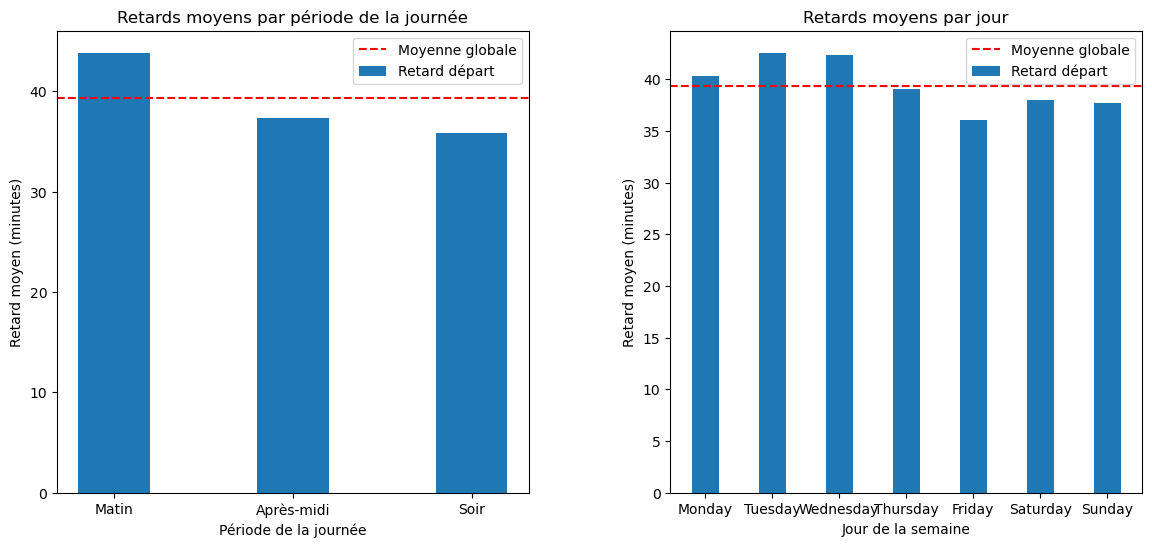

In [192]:
# Ordre des périodes de la journée
order_period = ['Matin', 'Après-midi', 'Soir']

# Groupement des données par période de la journée et calcul des retards moyens
period_dep_delay = vols_retardes.groupby('Period_Day')['Departure delay (Minutes)'].mean()

# Convertir l'index en un type catégoriel avec un ordre spécifique
period_dep_delay.index = pd.Categorical(period_dep_delay.index, categories=order_period, ordered=True)

# Réordonner les données
period_dep_delay = period_dep_delay.sort_index()

# Ordre des jours de la semaine
order_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Groupement des données par jour de la semaine et calcul des retards moyens
day_dep_delay = vols_retardes.groupby('Weekday_Flight')['Departure delay (Minutes)'].mean()

# Convertir l'index en un type catégoriel avec un ordre spécifique
day_dep_delay.index = pd.Categorical(day_dep_delay.index, categories=order_days, ordered=True)

# Réordonner les données
day_dep_delay = day_dep_delay.sort_index()

# Création de la figure et disposition des graphiques
plt.figure(figsize=(14, 6))

# Premier graphique : retards moyens par période de la journée
plt.subplot(1, 2, 1)  # 1 ligne, 2 colonnes, premier graphique
plt.bar(period_dep_delay.index, period_dep_delay.values, width=0.4, label='Retard départ')
plt.axhline(y=retard_moy, color='r', linestyle='--', label='Moyenne globale')
plt.title('Retards moyens par période de la journée')
plt.xlabel('Période de la journée')
plt.ylabel('Retard moyen (minutes)')
plt.legend()

# Deuxième graphique : retards moyens par jour de la semaine
plt.subplot(1, 2, 2)  # 1 ligne, 2 colonnes, deuxième graphique
plt.bar(day_dep_delay.index, day_dep_delay.values, width=0.4, label='Retard départ')
plt.axhline(y=retard_moy, color='r', linestyle='--', label='Moyenne globale')
plt.title('Retards moyens par jour')
plt.xlabel('Jour de la semaine')
plt.ylabel('Retard moyen (minutes)')
plt.legend()

# Ajuster l'espacement horizontal entre les graphiques
plt.subplots_adjust(wspace=0.3)

# Afficher les graphiques
plt.show()


<span style="color:darkmagenta;">**Quelle destination présente plus de retards?**</span>

<small>**Les vols retardés de la compagnie American Airlines de départ de l'aéroport JFK est à destination <span style="color:orange;">l’aéroport international O'Hare de Chicago (ORD)</span> se distingue par un fort retard moyen au départ proche des <span style="color:orange;">69 minutes</span>, soit une heure et 9 minutes en moyenne.
Inversement, les vols à destination <span style="color:orange;">l'aéroport international Raleigh Durham en Caroline du Nord (RDU)</span>sont ceux ayant le plus faible retard moyen de valeur <span style="color:orange;">5 minutes</span>.**</small>

/tmp/ipykernel_475574/3517589944.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=Airports_delays_rank['Retard moyen (Minutes)'], y=Airports_delays_rank['Destination Airport'], palette="viridis")


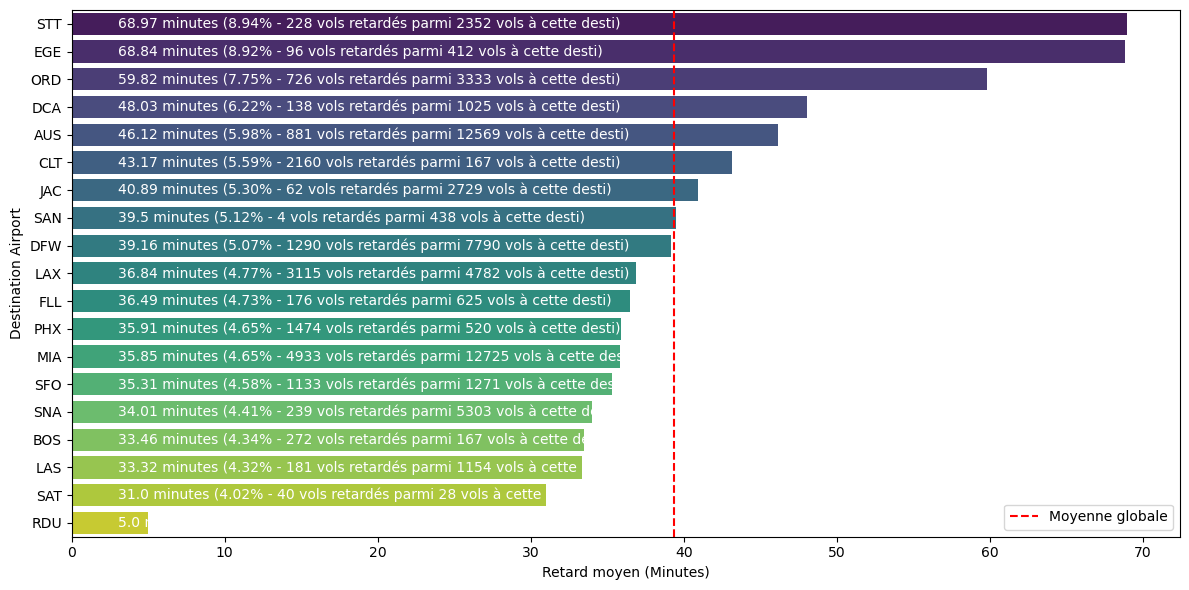

In [193]:
# Calcul des retards moyens de départ par aéroport et du nombre de vols
Airports_delays = vols_retardes.groupby(['Destination Airport']).agg({
    'Departure delay (Minutes)': 'mean',  # Moyenne des retards
    'Destination Airport': 'size'  # Compte le nombre de vols
}).rename(columns={'Destination Airport': 'Flight_Count','Departure delay (Minutes)': 'Retard moyen (Minutes)'}).reset_index()

Airports_delays = Airports_delays.sort_values(by='Flight_Count', ascending=False)
Airports_delays['Retard moyen (Minutes)'] = round(Airports_delays['Retard moyen (Minutes)'], 2)

total_delay_mean = Airports_delays['Retard moyen (Minutes)'].sum()

Airports_delays_rank = Airports_delays.sort_values(by='Retard moyen (Minutes)', ascending=False).reset_index()

Airports_delays_rank['Percentage'] = (Airports_delays_rank['Retard moyen (Minutes)'] / total_delay_mean) * 100

airport=df.groupby(['Destination Airport']).agg({
    'Departure delay (Minutes)': 'mean',  # Moyenne des retards
    'Destination Airport': 'size'  # Compte le nombre de vols
}).rename(columns={'Destination Airport': 'Flight_Count','Departure delay (Minutes)': 'Retard moyen (Minutes)'}).reset_index()
airport=airport.sort_values(by='Retard moyen (Minutes)', ascending=False).reset_index()


plt.figure(figsize=(12, 6))
bars = sns.barplot(x=Airports_delays_rank['Retard moyen (Minutes)'], y=Airports_delays_rank['Destination Airport'], palette="viridis")
plt.axvline(x=retard_moy, color='r', linestyle='--', label='Moyenne globale')
for i, (value, percent, count,nb) in enumerate(zip(
    Airports_delays_rank['Retard moyen (Minutes)'], 
    Airports_delays_rank['Percentage'], 
    Airports_delays_rank['Flight_Count'],
    airport['Flight_Count']
)):
    plt.text(3, i, f"{value} minutes ({percent:.2f}% - {count} vols retardés parmi {nb} vols à cette desti)", ha='left', va='center', color='white')
plt.legend()
plt.tight_layout()
plt.show()


<small>**<span style="color:orange;">Visualisation sur carte**</span></small>

<small>**En nous aidant d'une carte pour visualiser ces retards moyens par aéroport, nous constatons que nos aéroports de destination sont <span style="color:orange;">répartis sur l'ensemble du territoire des États Unis</span>. Nous pouvons aussi remarquer une plus forte concentration en <span style="color:orange;">sud ouest</span> et sur <span style="color:orange;">la cote nord-est autour de New York</span>.**</small>

In [194]:
import requests
import geopy
from geopy.geocoders import Nominatim
import folium

url="https://davidmegginson.github.io/ourairports-data/airports.csv"
# Effectuer la requête GET
response = requests.get(url)

# Vérifier si la requête a réussi
if response.status_code == 200:
    # Enregistrer le contenu dans un fichier CSV
    with open("aer.csv", "wb") as file:
        file.write(response.content)
    print("Téléchargement terminé ! Les données sont enregistrées dans 'aer.csv'.")
else:
    print(f"Erreur lors de la requête : {response.status_code}")

aer= pd.read_csv('/home/onyxia/work/Projet_Python-pour-la-data-science/aer.csv')
us_aeroport = aer[aer['iso_country'] == 'US'][['latitude_deg', 'longitude_deg', 'iata_code']]


Téléchargement terminé ! Les données sont enregistrées dans 'aer.csv'.


In [196]:

Airports_delays = pd.merge(Airports_delays, us_aeroport, left_on='Destination Airport', right_on='iata_code', how='left')


In [197]:
# Création d'un objet géocodeur Nominatim
geolocator = Nominatim(user_agent="my_geocoder")
 
# Géocodage d'une adresse
location = geolocator.geocode("STT")
 
# Affichage des informations de localisation
print("Latitude:", location.latitude, "Longitude:", location.longitude)

Airports_delays['latitude_deg'] = Airports_delays['latitude_deg'].fillna(location.latitude)
Airports_delays['longitude_deg'] = Airports_delays['longitude_deg'].fillna(location.longitude)

Airports_delays = Airports_delays.drop('iata_code', axis=1)


Latitude: 18.33476905 Longitude: -64.9724536459818


In [198]:

# Créer la carte centrée sur les États-Unis
m = folium.Map(location=[37.0902, -95.7129], zoom_start=5)  # Coordonnées approximatives du centre des USA

# Ajouter les points des aéroports avec les retards
for _, row in Airports_delays.iterrows():
    folium.CircleMarker(
        location=[row['latitude_deg'], row['longitude_deg']],
        radius=row['Retard moyen (Minutes)']*0.5,  # Ajuster la taille des points en fonction du retard
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.3,
        popup=f"{row['Destination Airport']}\nDelay: {row['Retard moyen (Minutes)']} minutes"
    ).add_to(m)

# Afficher la carte
m

<span style="color:darkmagenta;">**La saisonnalité des retards au départ au fil des années**</span>

<small>**Le graphique présente l'analyse mensuelle des retards au départ des vols de la compagnie American Airlines pour l'aéroport JFK sur différentes années. Les principales observations incluent <span style="color:orange;">des tendances saisonnières qui se répètent</span> d'une année à l'autre, avec des retards atteignant généralement leur pic durant <span style="color:orange;">l'été</span> et <span style="color:orange;">la fin de l'hiver (par exemple, en décembre)</span>. Exceptionnellement, l'année 2020 montre une diminution significative des retards, en lien avec la réduction du trafic aérien durant la pandémie de COVID-19. Ces dernières années, notamment en 2022 et 2023, une tendance à la hausse est observée, indiquant un retour à des fréquences de retards plus élevées ce qui peut être expliqué par le fait que les opérations de vol ont repris leur rythme normal.**</small>

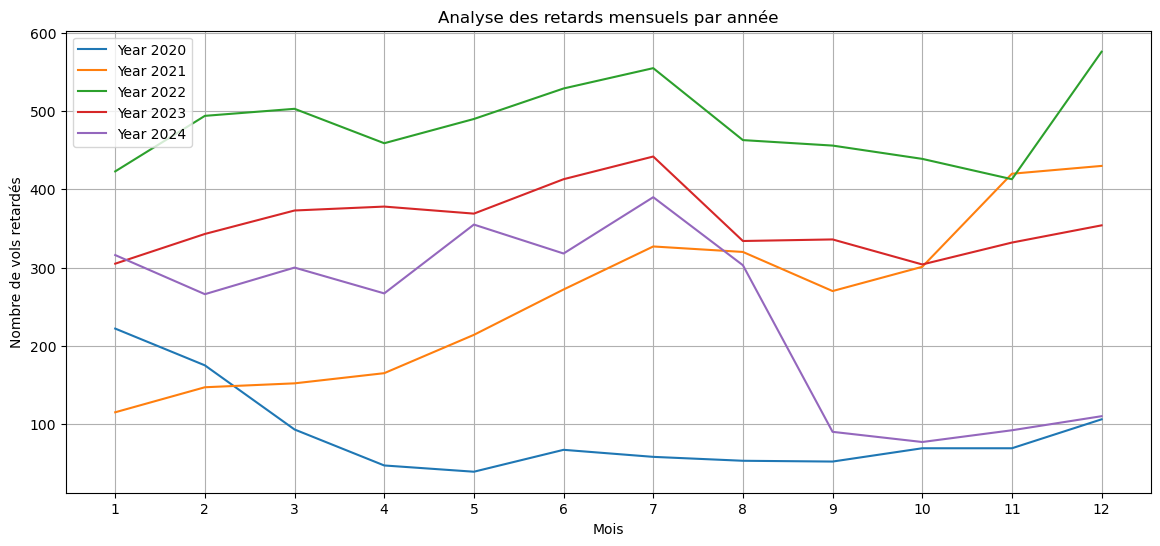

In [200]:
# Graphique des retards mensuels par année
vols_retardes['Year']=vols_retardes['Date'].dt.year

retards_mensuels = vols_retardes.groupby(['Year', 'Month'])['Retard'].sum().reset_index()
plt.figure(figsize=(14, 6))
for year in sorted(retards_mensuels['Year'].unique()):
    monthly_data = retards_mensuels[retards_mensuels['Year'] == year]
    plt.plot(monthly_data['Month'], monthly_data['Retard'], label=f'Year {year}')
plt.title('Analyse des retards mensuels par année')
plt.xlabel('Mois')
plt.ylabel('Nombre de vols retardés')
plt.xticks(range(1, 13))
plt.legend()
plt.grid(True)
plt.show()

<small>**Pour voir encore plus les résultats obtenus au dessous, nous avons essayé de <span style="color:orange;">tracer continuellement les tendances mensuelles des retards totaux au départ</span>. Nous pouvons clairement voir que les retards étaient beaucoup moins durant la pandémie.**</small>

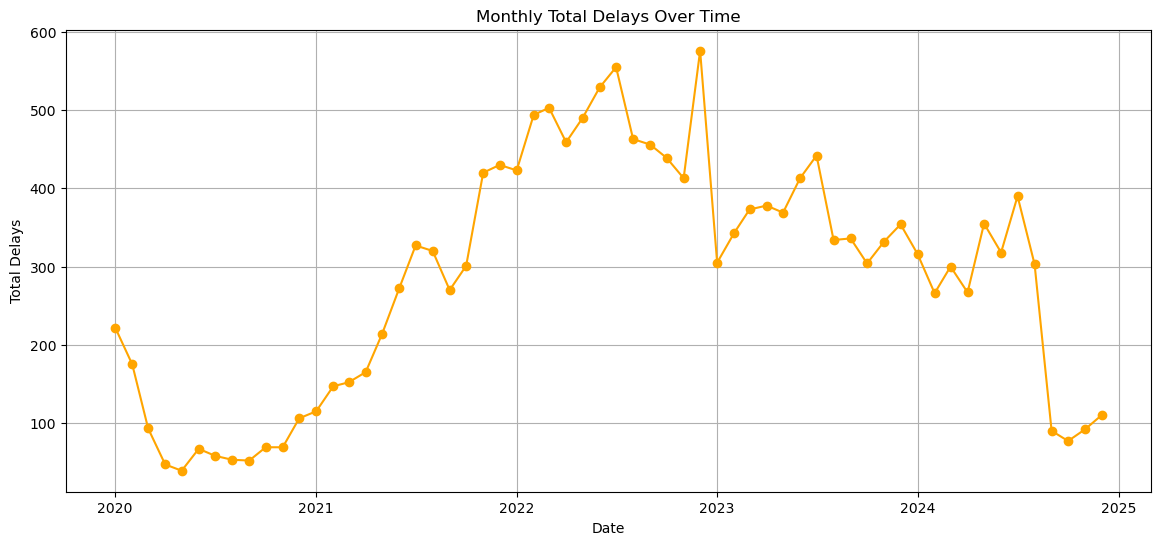

In [201]:
# 5 Fonction pour tracer les tendances mensuelles des retards totaux
def plot_monthly_trend(column, title, ylabel):
    trend_data = vols_retardes.groupby(['Year', 'Month'])[column].sum().reset_index()
    trend_data['Date'] = pd.to_datetime(trend_data[['Year', 'Month']].assign(day=1))#
    plt.figure(figsize=(14, 6))
    plt.plot(trend_data['Date'], trend_data[column], marker='o', color='orange')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()

# Graphiques des retards mensuels totaux
plot_monthly_trend('Retard', 'Monthly Total Delays Over Time', 'Total Delays')

<small>**Dans ce qui suit, nous allons essayé de faire des  visualisations pour nous aider à identifier les patterns distincts et les impacts de quelques variables sur les retards au départ au fil du temps.**</small>

<small>**<span style="color:orange;">Retards liés à la compagnie aérienne :</span> La baisse autour de 2020, probablement en raison de l'impact de la pandémie de COVID-19, peut être expliquée par le fait qu'American Airlines a dû réduire ses vols, ce qui a naturellement diminué les retards en raison de la baisse du trafic aérien. Après la pandémie, le retour de l'activité des vols à la normale a entraîner une reprise des retards indiquée par l'augmentation régulière du nombre des retards sur le graphe, imposant le retour des défis liés à la gestion d'un volume plus élevé de vols.**


**<span style="color:orange;">Retards liés au système de gestion du trafic aérien (NAS) :</span> Nous observons une baisse notable pendant la pandémie, suivie d'une augmentation progressive à mesure que le trafic aérien a été repris. Cela pourrait indiquer que le système de gestion du trafic aérien rencontre de nouveau des difficultés à gérer la reprise rapide du volume de vols, nécessitant ainsi des améliorations dans la gestion du trafic pour faire face à la croissance du nombre de vols.**

**<span style="color:orange;">Retards liés à la sécurité :</span> Généralement faibles en comparaison avec les autres causes de retards, mais avec des pics intermittents, indiquant des événements occasionnels de sécurité ayant un impact sur les vols.**</small>

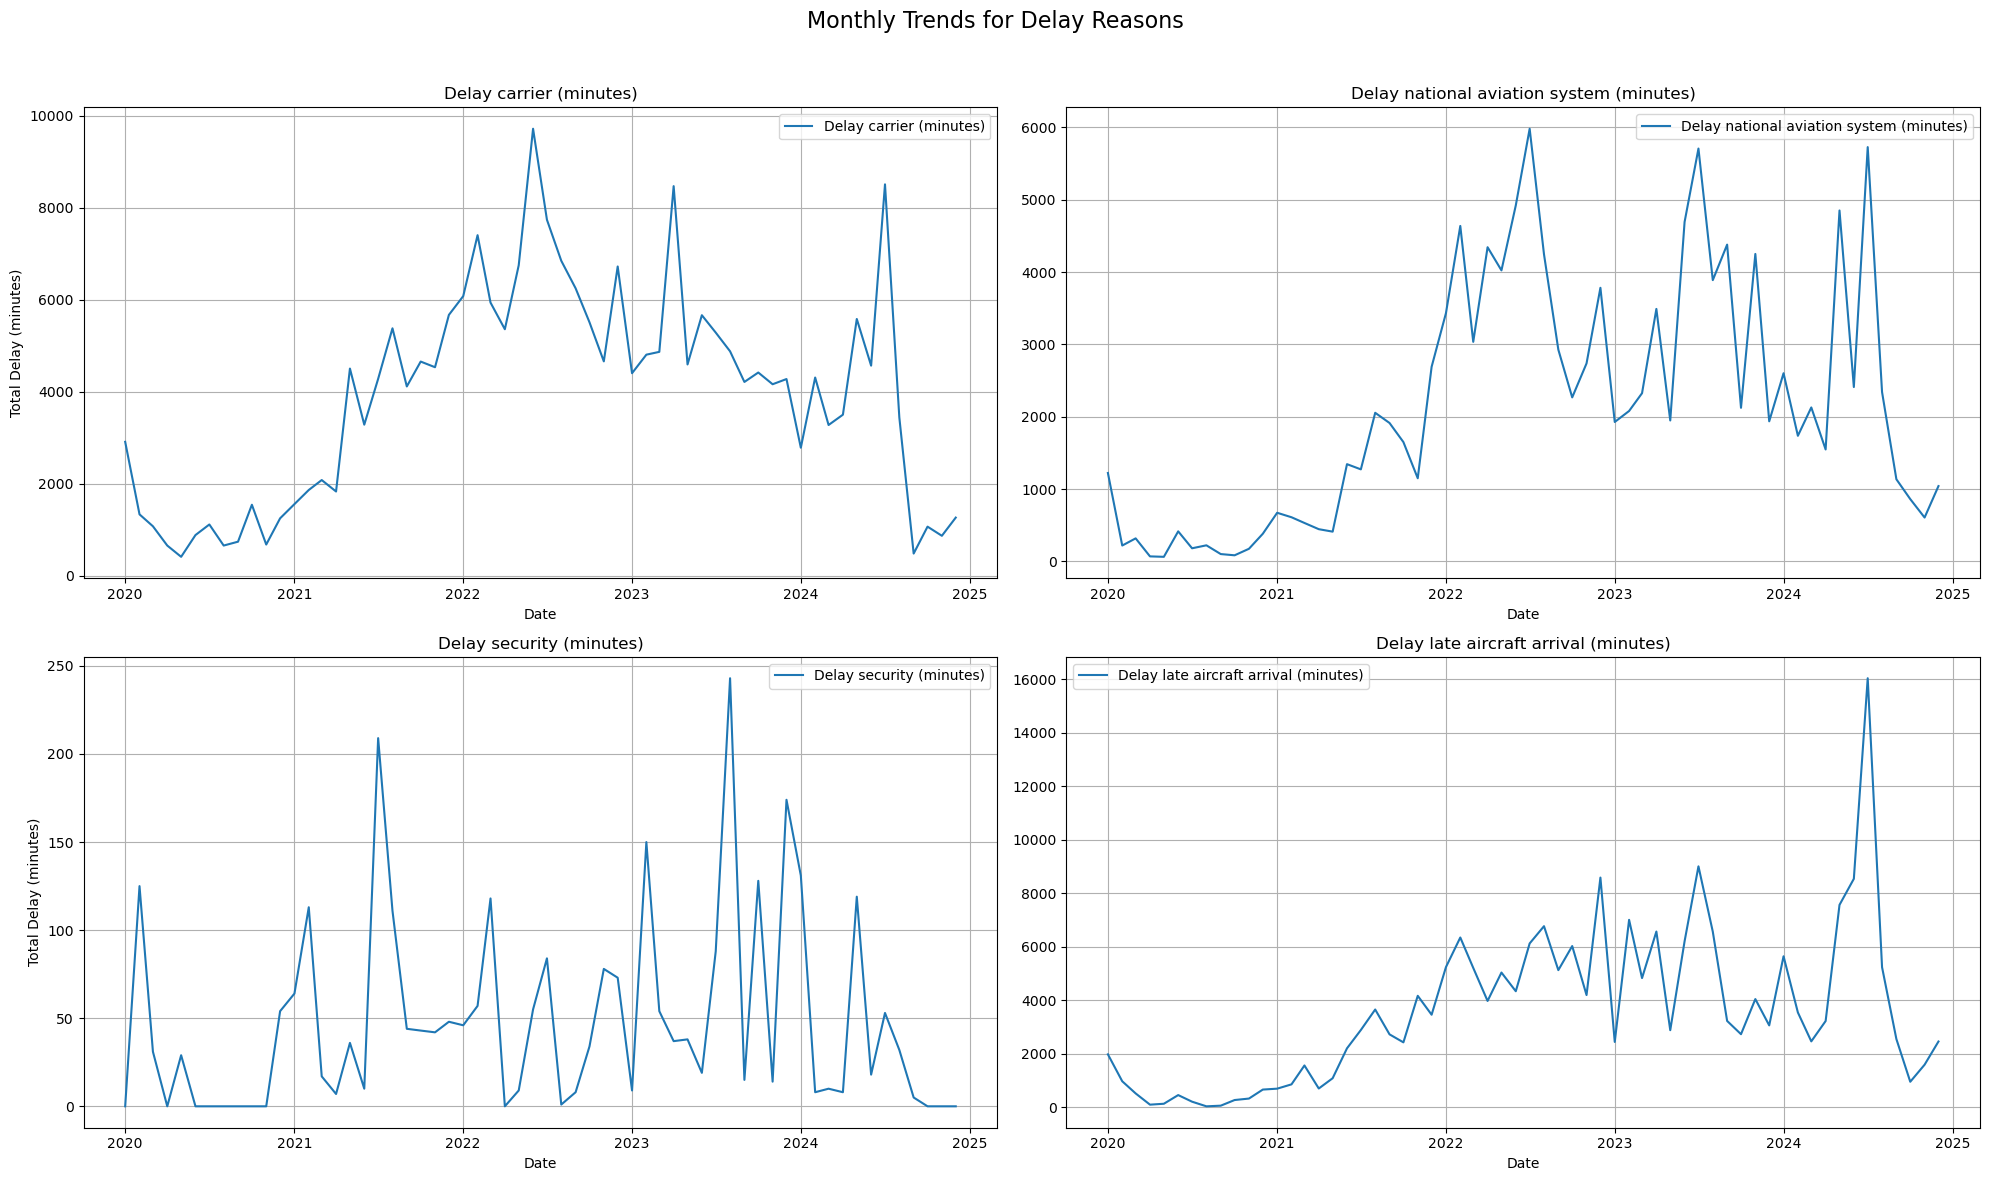

In [216]:
# Liste des colonnes correspondant aux raisons des retards
delay_reasons = ['Delay Carrier (Minutes)', 'Delay National Aviation System (Minutes)', 'Delay Security (Minutes)','Delay Late Aircraft Arrival (Minutes)']

# Afficher tous les graphiques des raisons des retards en une grille 2x2
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
fig.suptitle('Monthly Trends for Delay Reasons', fontsize=16)

for i, reason in enumerate(delay_reasons[:4]):  # Afficher uniquement 4 raisons sur 2x2
    ax = axes[i // 2, i % 2]
    trend_data = vols_retardes.groupby(['Year', 'Month'])[reason].sum().reset_index()
    trend_data['Date'] = pd.to_datetime(trend_data[['Year', 'Month']].assign(day=1))
    ax.plot(trend_data['Date'], trend_data[reason], label=reason.replace("_", " ").capitalize())
    ax.set_title(f'{reason.replace("_", " ").capitalize()}')
    ax.set_xlabel('Date')
    if i % 2 == 0:        
        ax.set_ylabel('Total Delay (minutes)')
    ax.legend()
    ax.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Après ici on étudie l'impact des conditions météo